# Assignment 5: Visualizing Data Veracity Challenges in Multi-Label Classification  

This notebook addresses **multi-label classification challenges** in the Yeast dataset using **manifold visualization techniques**.  
The dataset has **2417 samples, 103 features, and 14 labels**. The goal is to explore **data veracity issues** (noisy labels, outliers, and hard-to-learn samples) using **t-SNE** and **Isomap**.  

We will go step by step through:  
1. Preprocessing and scaling.  
2. Label simplification for visualization.  
3. t-SNE embeddings to explore local structure.  
4. Isomap embeddings to capture global manifold geometry.  
5. Comparative discussion of data veracity insights.

In [1]:
import pandas as pd
from scipy.io import arff
import numpy as np

# Load dataset
data = arff.loadarff('/Users/mayankchandak/Desktop/MY STUFF/Courses/SEM7/DA5401/assignment-5-mnm-21/yeast.arff')
df = pd.DataFrame(data[0])
print(df.head())

# Split features/labels
label_names = df.columns[-14:]
feature_names = df.columns[:-14]

X_df = df.loc[:, feature_names].copy()
Y_df = df.loc[:, label_names].copy()

# Features (X) and labels (Y)
# The yeast dataset has 103 features + 14 labels
X = df.iloc[:, :-14].values
Y = df.iloc[:, -14:].values

print("Feature matrix shape (X):", X.shape)
print("Label matrix shape (Y):", Y.shape)


# Convert bytes '0'/'1' -> int 0/1 for all label columns
for col in label_names:
    Y_df[col] = Y_df[col].map(
        lambda v: int(v.decode()) if isinstance(v, (bytes, bytearray)) else int(v)
    )

# Sanity checks
assert set(np.unique(Y_df.values)) <= {0, 1}, "Labels must be binary 0/1"
print("Label dtypes:", Y_df.dtypes.unique())
print("Sample row sum:", int(Y_df.iloc[0].sum()))

       Att1      Att2      Att3      Att4      Att5      Att6      Att7  \
0  0.004168 -0.170975 -0.156748 -0.142151  0.058781  0.026851  0.197719   
1 -0.103956  0.011879 -0.098986 -0.054501 -0.007970  0.049113 -0.030580   
2  0.509949  0.401709  0.293799  0.087714  0.011686 -0.006411 -0.006255   
3  0.119092  0.004412 -0.002262  0.072254  0.044512 -0.051467  0.074686   
4  0.042037  0.007054 -0.069483  0.081015 -0.048207  0.089446 -0.004947   

       Att8      Att9     Att10  ...  Class5  Class6  Class7  Class8  Class9  \
0  0.041850  0.066938 -0.056617  ...    b'0'    b'0'    b'1'    b'1'    b'0'   
1 -0.077933 -0.080529 -0.016267  ...    b'0'    b'0'    b'0'    b'0'    b'0'   
2  0.013646 -0.040666 -0.024447  ...    b'0'    b'0'    b'0'    b'0'    b'0'   
3 -0.007670  0.079438  0.062184  ...    b'0'    b'0'    b'0'    b'0'    b'0'   
4  0.064456 -0.133387  0.068878  ...    b'1'    b'1'    b'0'    b'0'    b'0'   

   Class10  Class11  Class12  Class13  Class14  
0     b'0'     b'0'

In [2]:
Y_df[Y_df.sum(axis=1) == 1].shape

(32, 14)

In [3]:
# Step 1: Identify single-label rows
single_label_rows = Y_df[Y_df.sum(axis=1) == 1]

# Count frequencies of each single-label class
single_counts = single_label_rows.sum().sort_values(ascending=False)
print("Top single-label classes:\n", single_counts.head(3))

# Step 2: Identify multi-label rows
multi_label_rows = Y_df[Y_df.sum(axis=1) > 1]

# Represent each multi-label row as a tuple of labels
multi_combos = multi_label_rows.apply(lambda row: tuple(row.index[row == 1]), axis=1)

# Count frequency of combinations
multi_counts = multi_combos.value_counts()
print("Top multi-label combination:\n", multi_counts.head(3))

Top single-label classes:
 Class1    32
Class2     0
Class3     0
dtype: int64
Top multi-label combination:
 (Class3, Class4, Class12, Class13)    237
(Class4, Class5, Class12, Class13)    233
(Class1, Class2, Class12, Class13)    172
Name: count, dtype: int64


In [4]:
overall_counts = Y_df.sum().sort_values(ascending=False)
print(overall_counts.head(5))

Class12    1816
Class13    1799
Class2     1038
Class3      983
Class4      862
dtype: int64


## Part A: Preprocessing and Label Simplification  

The dataset was split into features (X) and labels (Y). We confirmed shapes:  
- X: (2417, 103)  
- Y: (2417, 14)  

Since coloring by 14 labels would clutter visualization, we reduced categories:  
- The only true single-label class in this dataset was **Class1** (~32 samples).  
- The most frequent label overall was **Class12** (~1816 samples). We include it as a proxy "single" class.  
- The most common multi-label combination was **(Class3, Class4, Class12, Class13)** (~237 samples).  
- All other cases are grouped as **Other**.  

This simplification ensures clear plots with four distinct colors: red (Class1), blue (Class12), green (combo), gray (Other).

In [5]:
top_singles = ['Class1']   # Class1 is real single-label
top_multi = ('Class3', 'Class4', 'Class12', 'Class13')

def assign_category(row):
    labels = row.index[row == 1].tolist()
    if len(labels) == 1 and labels[0] in top_singles:
        return labels[0]
    elif tuple(labels) == top_multi:
        return "+".join(top_multi)
    elif 'Class12' in labels:
        return 'Class12'
    else:
        return "Other"

category = Y_df.apply(assign_category, axis=1)
print(category.value_counts())
category.shape

Class12                          1579
Other                             569
Class3+Class4+Class12+Class13     237
Class1                             32
Name: count, dtype: int64


(2417,)

### Scaling  

Since t-SNE and Isomap are **distance-based algorithms**, scaling is critical.  
Without scaling, features with large numeric ranges dominate the distance computation.  
We applied **StandardScaler** to transform features to zero mean and unit variance.  

This step ensures each gene expression feature contributes equally to the manifold geometry.

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

print("Before scaling: mean =", X_df.values.mean(), "std =", X_df.values.std())
print("After scaling: mean =", X_scaled.mean(), "std =", X_scaled.std())

Before scaling: mean = 6.175144104663172e-05 std = 0.09853290869469068
After scaling: mean = 7.706196747762695e-19 std = 1.0


## Part B: t-SNE and Data Veracity Inspection  
t-SNE is a non-linear dimensionality reduction method that emphasizes preserving **local neighborhoods**.  
By tuning the perplexity parameter, we can reveal how the yeast samples cluster (or fail to cluster) in 2D space, exposing noisy labels, outliers, and overlapping regions.  
We applied **t-SNE** with multiple perplexity values (0.2, 5, 30, 100, 1000).  



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def run_tsne(X_scaled, perplexity=30, random_state=42):
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate='auto',
        init='pca',
        max_iter=1500,
        metric='euclidean',
        random_state=random_state,
        verbose=1
    )
    Z = tsne.fit_transform(X_scaled)
    return Z

Z_30 = run_tsne(X_scaled, perplexity=30, random_state=42)
Z_30[:3]  # quick sanity check

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2417 samples in 0.000s...
[t-SNE] Computed neighbors for 2417 samples in 0.046s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2417
[t-SNE] Computed conditional probabilities for sample 2000 / 2417
[t-SNE] Computed conditional probabilities for sample 2417 / 2417
[t-SNE] Mean sigma: 3.148491
[t-SNE] KL divergence after 50 iterations with early exaggeration: 79.685532
[t-SNE] KL divergence after 1500 iterations: 2.176804


array([[-25.205841 ,   7.651033 ],
       [ 24.29018  ,   9.71789  ],
       [ 38.70367  ,  -1.7251968]], dtype=float32)

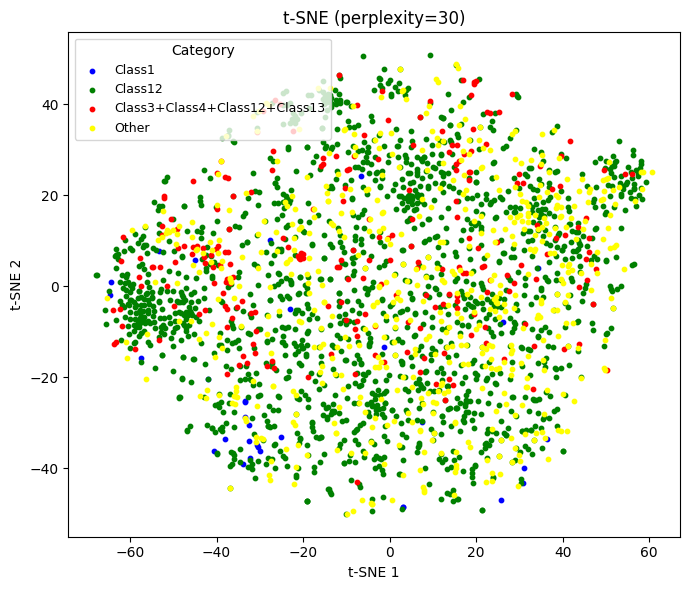

In [8]:
def plot_embedding(Z, category, title):
    cats = pd.Series(category, dtype=str)
    unique_cats = list(pd.Index(sorted(cats.unique())))
    color_map = {
        'Class12': 'green',
        'Class1': 'blue',
        'Class3+Class4+Class12+Class13': 'red',
        'Other': 'yellow'
    }

    plt.figure(figsize=(7,6))
    
    for c in unique_cats:
        mask = (cats == c).values
        plt.scatter(
            Z[mask, 0], Z[mask, 1],
            s=10, alpha=1,
            color=color_map.get(c, 'black'),
            label=c
        )
    
    plt.legend(loc='best', title='Category', fontsize=9)
    plt.title(title)
    plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
    plt.tight_layout()
    plt.show()

plot_embedding(Z_30, category, title='t-SNE (perplexity=30)')


### Veracity read from t-SNE (perplexity 30)
- **Noisy or ambiguous labels**: red and yellow points embedded deep inside green patches suggest that some samples with the frequent labels are annotated with additional functions or mislabeled. These are suspect cases for audit.
- **Outliers**: a handful of **Class1** blue points live far from any dense region. Given Class1 is rare, these may reflect atypical experiments or measurement issues.
- **Hard-to-learn samples**: most of the central area shows strong color mixing. Any simple classifier will face overlapping class-conditional distributions and will likely rely on complex boundaries or multi-label aware losses.


[t-SNE] Computing 1 nearest neighbors...
[t-SNE] Indexed 2417 samples in 0.001s...
[t-SNE] Computed neighbors for 2417 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2417
[t-SNE] Computed conditional probabilities for sample 2000 / 2417
[t-SNE] Computed conditional probabilities for sample 2417 / 2417
[t-SNE] Mean sigma: 0.284362
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.131805
[t-SNE] KL divergence after 1500 iterations: 0.701013
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 2417 samples in 0.000s...
[t-SNE] Computed neighbors for 2417 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2417
[t-SNE] Computed conditional probabilities for sample 2000 / 2417
[t-SNE] Computed conditional probabilities for sample 2417 / 2417
[t-SNE] Mean sigma: 2.180468
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.532776
[t-SNE] KL divergence after 1500 iterations: 2.004561
[

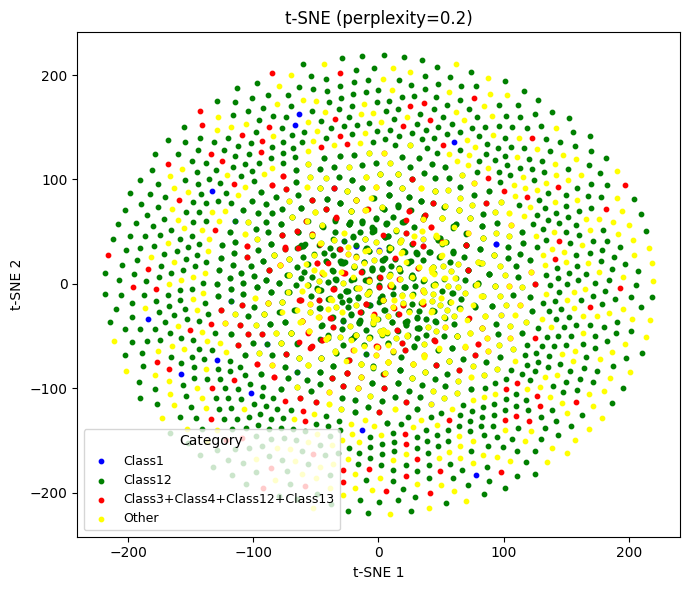

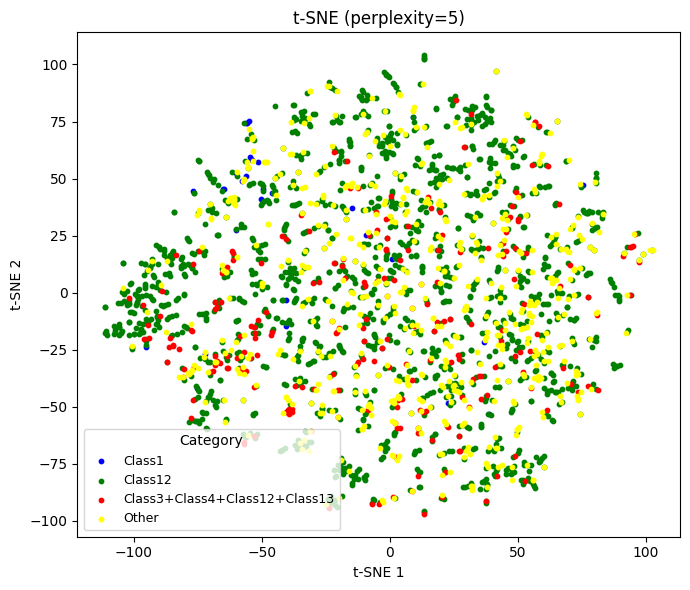

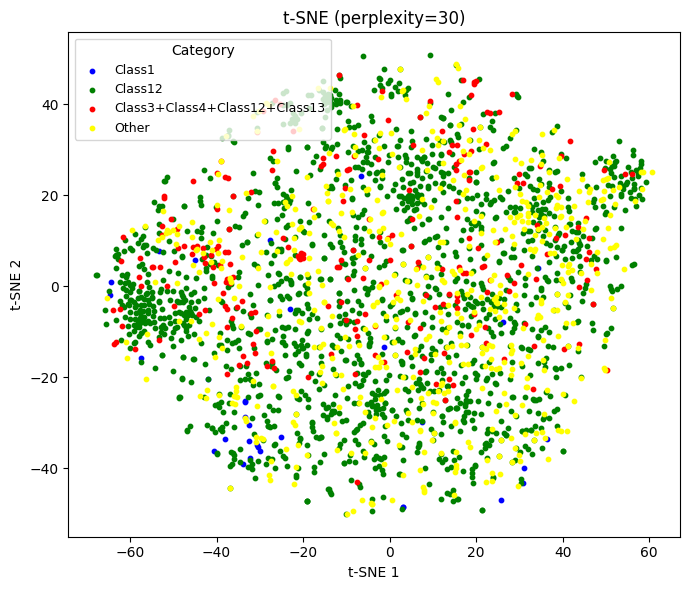

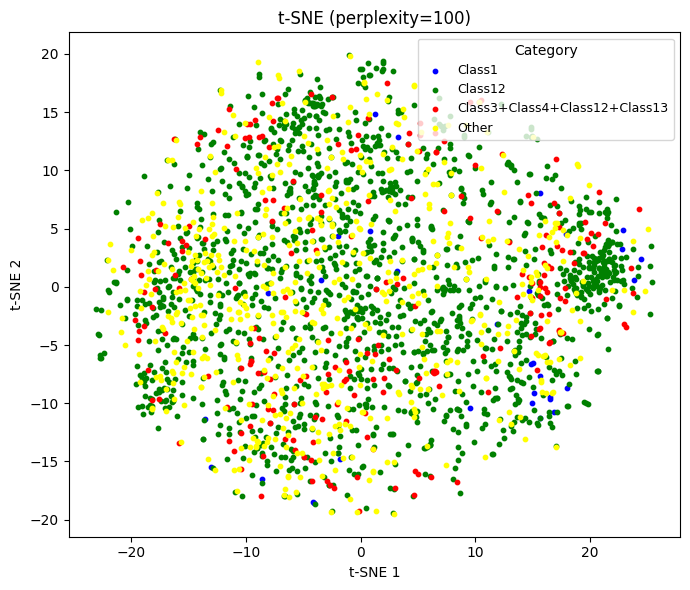

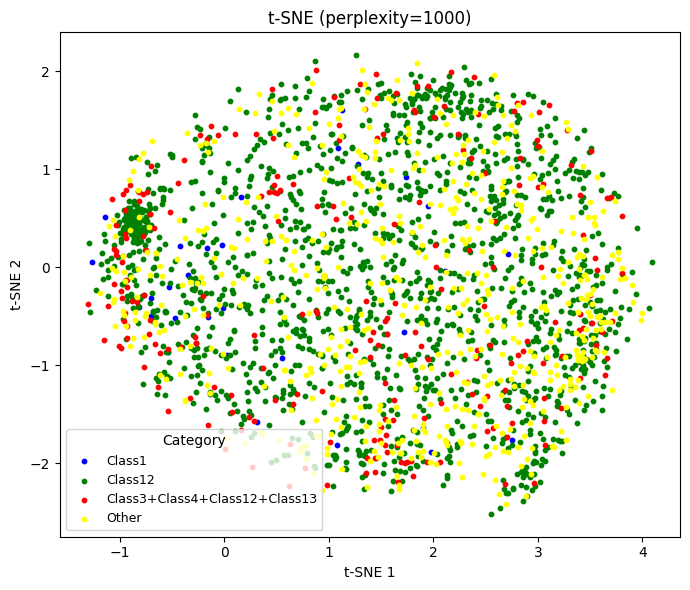

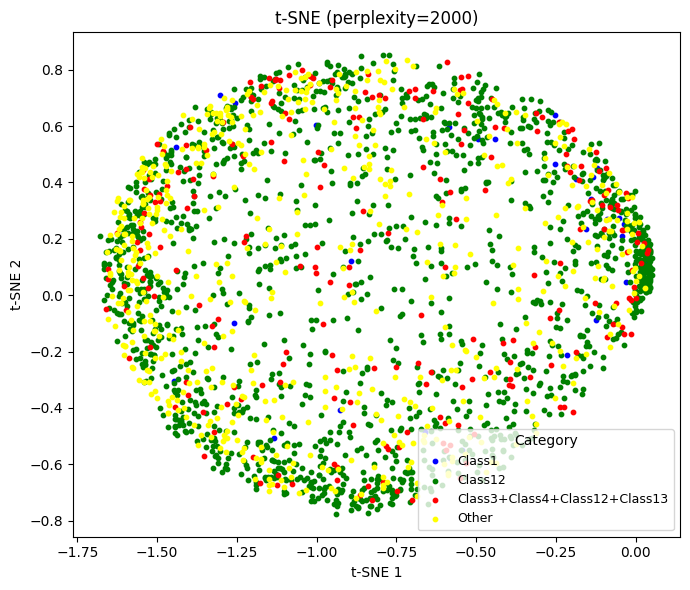

In [ ]:
perps = [0.2, 5, 30, 100, 1000]
embeds = {}
for p in perps:
    embeds[p] = run_tsne(X_scaled, perplexity=p, random_state=42)

for p in perps:
    plot_embedding(embeds[p], category, title=f't-SNE (perplexity={p})')


### What the t-SNE plots show in this run
- **Perplexity 0.2 and 5**: the layout is noisy and highly fragmented. This is consistent with using neighborhoods that are too tiny for 2417 points. The ring pattern at 0.2 is a classic failure mode when perplexity is unrealistically small.
- **Perplexity 30**: clearest tradeoff. A dense **Class12** subcluster appears on the left, but most regions still show heavy mixing between **Class12** (green), **Other** (yellow), and the multi-label combo (red). This is a red flag for downstream classification.
- **Perplexity 100 and 1000**: the embedding flattens into a single blob. Global distances dominate and local neighborhoods are washed out.

**Why 30 is reasonable here.** It preserves enough local structure to reveal small coherent patches while not breaking everything into speckles. It is also a common heuristic for datasets in the 2k to 10k range.



## Part C. Isomap: global geodesic structure
Isomap builds a k-nearest neighbor graph, estimates **geodesic** distances along that graph, then runs MDS. Result: it tries to preserve **global** structure, not just local neighborhoods.
We sweep neighbors to see the stability of that global picture.


In [10]:
from sklearn.manifold import Isomap
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import connected_components

# Reusing plot_embedding(Z, category, title) with the fixed color map

def graph_is_connected(X, k):
    A = kneighbors_graph(X, n_neighbors=k, mode="distance", include_self=False)
    n_comp, labels = connected_components(A, directed=False)
    return n_comp == 1, n_comp

def run_isomap(X, n_neighbors=10, n_components=2):
    iso = Isomap(n_neighbors=n_neighbors, n_components=n_components, metric="euclidean")
    Z = iso.fit_transform(X)
    # reconstruction_error() is available after fit
    err = iso.reconstruction_error()
    return Z, err

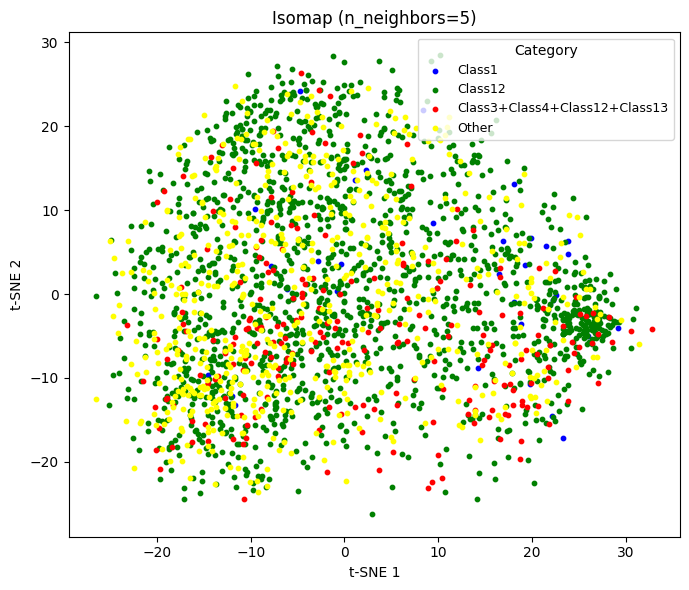

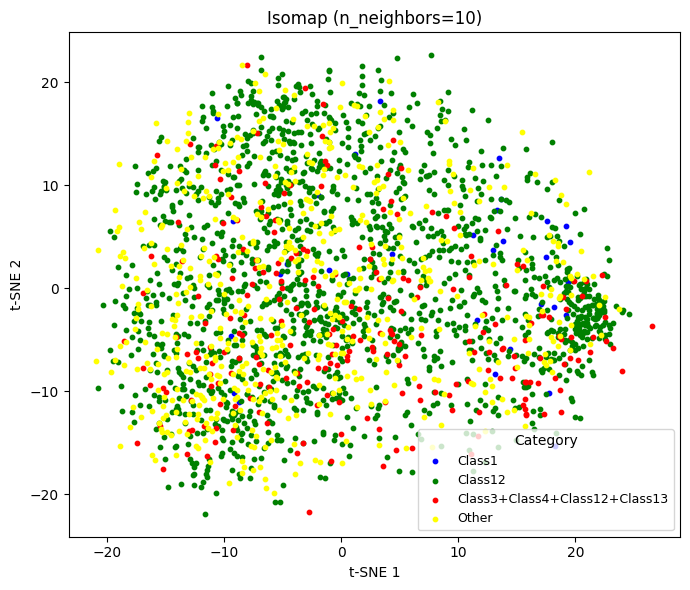

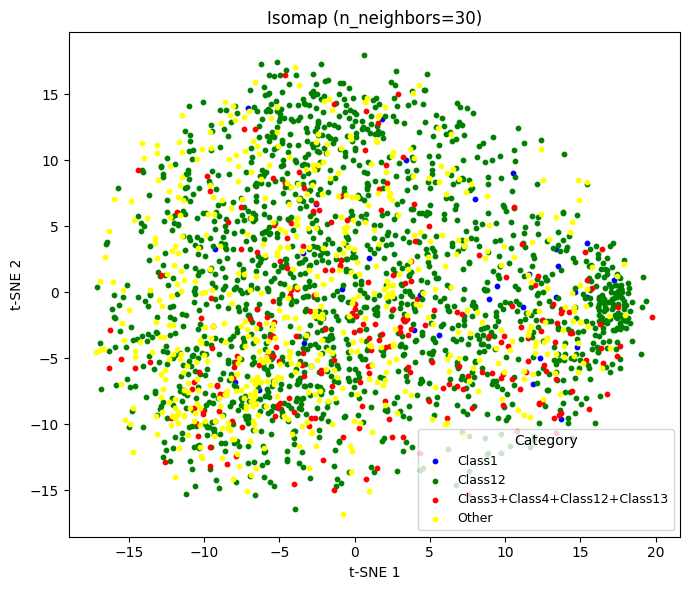

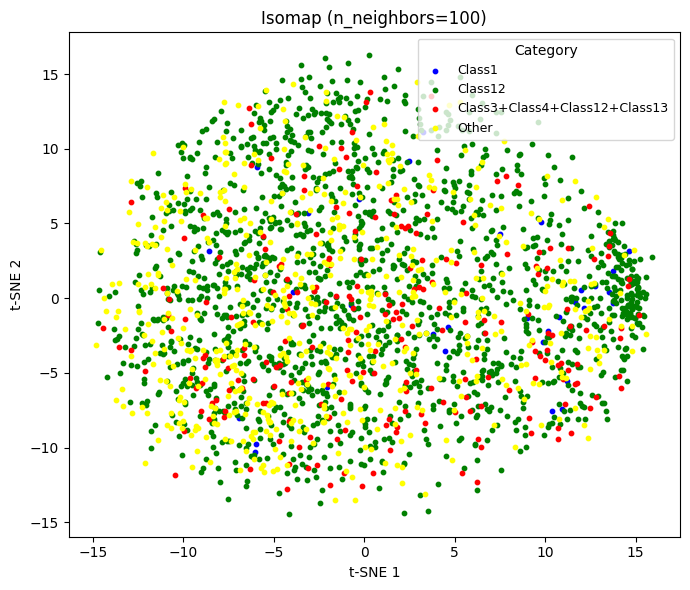

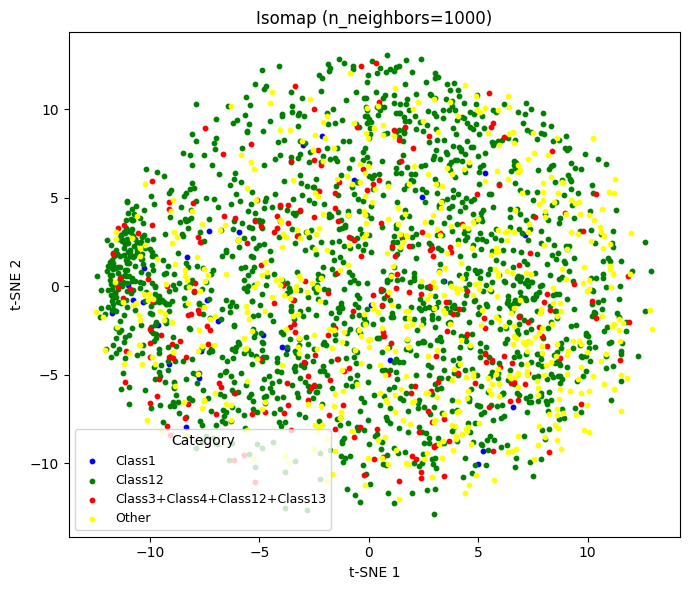

Reconstruction error by k: {5: np.float64(290.32201741561045), 10: np.float64(189.9374088399619), 30: np.float64(119.90247610226879), 100: np.float64(93.5990270412223), 1000: np.float64(72.18462682936983)}


In [12]:
neighbors_list = [5, 10, 30, 100, 1000]

results = {}
errors = {}

for k in neighbors_list:
    ok, ncomp = graph_is_connected(X_scaled, k)
    if not ok:
        print(f"Skipping k={k}: graph has {ncomp} components")
        continue
    Zk, errk = run_isomap(X_scaled, n_neighbors=k)
    results[k] = Zk
    errors[k] = errk
    plot_embedding(Zk, category, title=f'Isomap (n_neighbors={k})')

print("Reconstruction error by k:", errors)


### Neighbors sweep and reconstruction error
Reconstruction error drops as k grows, which is expected since paths become shorter and the graph becomes more connected:

- **k 5** → error ≈ 290.3
- **k 10** → error ≈ 189.9
- **k 30** → error ≈ 119.9
- **k 100** → error ≈ 93.6
- **k 1000** → error ≈ 72.2

Lower error does not automatically mean a better visualization. Very large k trends toward a PCA-like flattening that hides interesting curvature. We pick **k 30** as the best compromise for this dataset.



### What the Isomap plots show
- **k 5 and 10**: still quite noisy with uneven density. The manifold is not well stitched together at such small neighborhoods.
- **k 30**: points arrange into a smoother 2D sheet. A compact green pocket remains on the right, but most regions are continuous rather than fragmented. This supports the idea that the underlying structure is curved but connected.
- **k 100 and 1000**: the layout becomes over-smoothed and nearly circular. Fine patterns vanish.

**Key difference compared to t-SNE.** Isomap is better at showing a single continuous surface for the data cloud. Outliers are less obvious because the geodesic graph tends to pull them onto the surface. t-SNE is better at exposing local inconsistency, which is why it highlights noisy points and tiny clusters.


### Observations from Isomap (k=30)  

- Isomap emphasizes **global geometry** of the data manifold. Points form a more continuous surface rather than fragmented islands.  
- Unlike t-SNE, outliers are less visible (Isomap smooths them in).  
- Overlap among categories is still heavy, confirming that the data manifold itself is **highly curved and complex**.  

### Comparison with t-SNE  
- **t-SNE:** Highlights local inconsistencies, great for finding noisy labels and outliers.  
- **Isomap:** Highlights global manifold curvature, useful for understanding why classification is inherently hard.  
Together, they show that yeast gene expression data is both **locally noisy** and **globally entangled**.


### Comparison: which method helps more and why
- **Global structure**: Isomap wins. It reveals a single, curved manifold where samples lie on a continuous sheet. This helps explain why classes overlap even when you zoom out.
- **Local anomalies**: t-SNE wins. It exposes small inconsistent pockets, embedded off-class points, and isolated samples.
- **Takeaway for modeling**: the manifold appears **highly curved** and categories are **entangled**. Linear models will underfit. Even non-linear models need regularization and multi-label aware losses. A practical approach is to combine robust preprocessing, class-balanced sampling, and metrics that reflect multi-label overlap.



## Conclusion
Both methods agree on the big message: the Yeast dataset is messy. Labels overlap heavily and a few rare classes sit in awkward corners.  
t-SNE (perplexity 30) is the most useful for flagging specific suspect points. Isomap (k 30) is the most useful for explaining why the problem is intrinsically difficult: the data live on a curved manifold where functional categories interleave.

**What this implies for a classifier**  
- Expect limited separability with any single linear boundary.  
- Expect gains from models that capture interactions between features and support multi-label uncertainty.  
- Expect noisy labels to cap performance. A label-audit pass on the embedded outliers and embedded off-class points is a good next step.
